In [1]:
import os
import pandas as pd
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
from collections import Counter
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
import nltk

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from torchvision import models, transforms
from PIL import Image

c:\Users\tanus\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("./Dataset/captions.txt")
df

,Image Name,Caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .


In [3]:
img_path = './Dataset/Images/'

df['Image Name'] = img_path + df['Image Name']
df


,Image Name,Caption
0,./Dataset/Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,./Dataset/Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,./Dataset/Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,./Dataset/Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,./Dataset/Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
40450,./Dataset/Images/997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,./Dataset/Images/997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,./Dataset/Images/997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,./Dataset/Images/997722733_0cb5439472.jpg,A rock climber in a red shirt .


In [4]:
import cv2
x = cv2.imread(df['Image Name'][100])
cv2.imshow('Image', x)
cv2.waitKey(0)
cv2.destroyAllWindows()

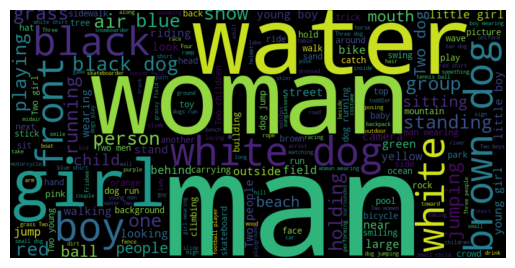

In [8]:
words = " ".join(df['Caption'].values)
wordcloud = WordCloud(width=800, height=400).generate(words)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tanus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


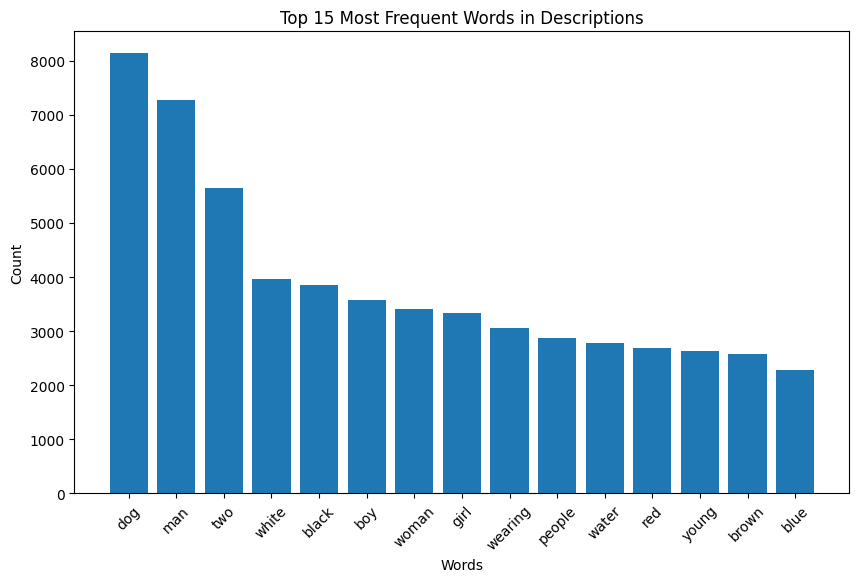

In [9]:
nltk.download('stopwords')

# Tokenize the words in the descriptions
descriptions = " ".join(df['Caption'].values)
words = re.findall(r'\w+', descriptions.lower())  # Convert to lowercase and extract words

# Remove stopwords (like 'the', 'and', etc.)
stop_words = set(stopwords.words('english'))
filtered_words = [word for word in words if word not in stop_words]

# Count the frequency of each word
word_counts = Counter(filtered_words)

# Get the 15 most common words
most_common_words = word_counts.most_common(15)

# Separate the words and their counts
words, counts = zip(*most_common_words)

# Plot a bar chart of the most frequent words
plt.figure(figsize=(10,6))
plt.bar(words, counts)
plt.title('Top 15 Most Frequent Words in Descriptions')
plt.xlabel('Words')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


### Model Building

In [10]:
# 1. Define the Dataset
class MultimodalDataset(Dataset):
    def __init__(self, dataframe, image_transform, tokenizer, max_length=128):
        self.dataframe = dataframe
        self.image_transform = image_transform
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe.iloc[idx, 0]  # Assuming image path is the first column
        caption = self.dataframe.iloc[idx, 1]     # Assuming description is the second column

        # Load and transform the image
        image = Image.open(image_path).convert('RGB')
        image = self.image_transform(image)

        # Tokenize the text description without padding yet
        inputs = self.tokenizer(caption, return_tensors="pt", truncation=True, max_length=self.max_length)
        text_inputs = {key: value.squeeze(0) for key, value in inputs.items()}  # Remove batch dimension for BERT inputs

        return image, text_inputs

def collate_fn(batch):
    images = torch.stack([item[0] for item in batch], dim=0)  # Stack images

    # Extract input_ids and attention_mask and pad them to the longest in the batch
    input_ids = [item[1]['input_ids'] for item in batch]
    attention_mask = [item[1]['attention_mask'] for item in batch]
    
    # Pad sequences to the longest in the batch
    input_ids_padded = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True)
    attention_mask_padded = torch.nn.utils.rnn.pad_sequence(attention_mask, batch_first=True)
    
    text_inputs = {
        'input_ids': input_ids_padded,
        'attention_mask': attention_mask_padded
    }

    return images, text_inputs


# 2. Multimodal Model
class MultimodalModel(nn.Module):
    def __init__(self):
        super(MultimodalModel, self).__init__()
        self.image_fc = nn.Linear(2048, 512)  # ResNet outputs 2048 features
        self.text_fc = nn.Linear(768, 512)    # BERT outputs 768 features
        self.fc = nn.Linear(1024, 1)          # Final layer for binary classification
        
    def forward(self, image_features, text_features):
        image_out = self.image_fc(image_features)
        text_out = self.text_fc(text_features)
        combined = torch.cat((image_out, text_out), dim=1)
        out = self.fc(combined)
        return out

# 3. Define the training loop
def train_model(model, dataloader, criterion, optimizer, num_epochs=5, device='cpu'):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        
        for batch in dataloader:
            images, text_inputs = batch
            images = images.to(device)

            # Extract text inputs and pass to BERT
            input_ids = text_inputs['input_ids'].to(device)
            attention_mask = text_inputs['attention_mask'].to(device)
            
            # Extract text features using BERT
            with torch.no_grad():
                text_outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
                text_features = text_outputs.last_hidden_state[:, 0, :]  # Use [CLS] token representation

            # Extract image features
            image_features = resnet(images)
            image_features = image_features.view(image_features.size(0), -1)  # Flatten the image features

            # Forward pass through the multimodal model
            outputs = model(image_features, text_features)
            
            # Assuming binary labels for the task; replace with your actual labels
            labels = torch.tensor([[1], [0]], dtype=torch.float32).to(device)  # Example labels, adjust based on dataset

            loss = criterion(outputs, labels)
            
            # Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(dataloader):.4f}")

# 4. Main block to tie everything together
if __name__ == "__main__":
    # Image transformation
    image_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Initialize the BERT tokenizer and model for text encoding
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    bert_model = BertModel.from_pretrained('bert-base-uncased')

    # Initialize the ResNet model for image feature extraction
    resnet = models.resnet50(pretrained=True)
    resnet = nn.Sequential(*list(resnet.children())[:-1])  # Remove the classification layer
    
    # Create the dataset and dataloader
    dataset = MultimodalDataset(df, image_transform, tokenizer)
    dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

    # Initialize the multimodal model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = MultimodalModel().to(device)

    # Loss and optimizer
    criterion = nn.BCEWithLogitsLoss()  # For binary classification
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # Train the model
    train_model(model, dataloader, criterion, optimizer, num_epochs=5, device=device)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument index in method wrapper_CUDA__index_select)

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertModel
from torchvision import models, transforms
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd

# Check if GPU is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Dataset class (for image paths and text descriptions)
class MultimodalDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe.iloc[idx, 0]
        description = self.dataframe.iloc[idx, 1]
        
        # Load image
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        
        # Tokenize text description
        text_inputs = self.tokenizer(description, return_tensors='pt', padding='max_length', truncation=True, max_length=128)
        
        # Since DataLoader collates batch tensors, squeeze to remove extra dimension
        text_inputs = {key: val.squeeze(0) for key, val in text_inputs.items()}
        
        return image, text_inputs

# Define transformation for images (ResNet input)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create your dataset and dataloader
dataset = MultimodalDataset(df, transform=transform)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# Define the multimodal model class
class MultimodalModel(nn.Module):
    def __init__(self, image_feature_size=2048, text_feature_size=768, hidden_size=512, output_size=1):
        super(MultimodalModel, self).__init__()
        self.fc1 = nn.Linear(image_feature_size + text_feature_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, image_features, text_features):
        combined_features = torch.cat((image_features, text_features), dim=1)
        x = self.relu(self.fc1(combined_features))
        x = torch.sigmoid(self.fc2(x))
        return x

# Initialize the model
model = MultimodalModel().to(device)

# Load pretrained BERT model and move it to GPU
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)

# Load pretrained ResNet model and move it to GPU
resnet = models.resnet50(pretrained=True)
resnet = nn.Sequential(*list(resnet.children())[:-1])  # Remove the classification layer
resnet = resnet.to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training function
def train_model(model, dataloader, criterion, optimizer, num_epochs=5, device='cuda'):
    model.train()
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        
        for batch in dataloader:
            images, text_inputs = batch
            images = images.to(device)

            # Extract text inputs and move them to the appropriate device
            input_ids = text_inputs['input_ids'].to(device)
            attention_mask = text_inputs['attention_mask'].to(device)
            
            # Extract text features using BERT
            with torch.no_grad():
                text_outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
                text_features = text_outputs.last_hidden_state[:, 0, :]  # Use [CLS] token representation

            # Extract image features
            with torch.no_grad():
                image_features = resnet(images)
                image_features = image_features.view(image_features.size(0), -1)  # Flatten the image features

            # Forward pass through the multimodal model
            outputs = model(image_features, text_features)
            
            # Assuming binary labels for the task; replace with your actual labels
            labels = torch.tensor([[1], [0]], dtype=torch.float32).to(device)  # Example labels, adjust based on dataset

            loss = criterion(outputs, labels)
            
            # Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(dataloader):.4f}")

# Train the model
train_model(model, dataloader, criterion, optimizer, num_epochs=5, device=device)


Using device: cuda


c:\Users\tanus\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\tanus\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\modeling_utils.py:454: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unle